# Example: Custom value function and different interaction indices

In [1]:
import xgboost

from folktables import ACSDataSource, ACSIncome

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", rc={'axes.linewidth': 2, 'grid.linewidth': 1},  font_scale=1.5)

import nshap

### Define the value function

In [2]:
import math

p = 0.1
def v_func(x, S):
    """ The value function from Example 1 in the Faith Shap paper.
    """
    if len(S) <= 1:
        return 0
    return len(S) - p*math.comb(len(S),2)


v_func(None, [1,2,3,4])

3.4

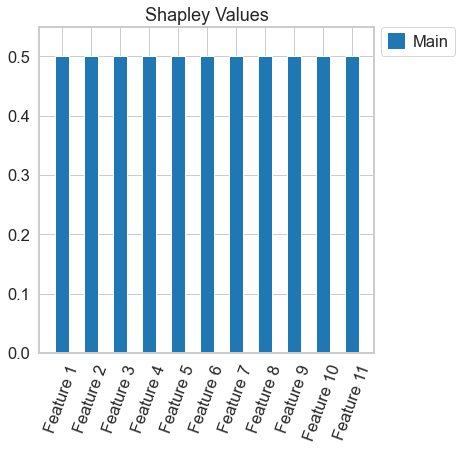

Shapley Values 5.4999999999999325


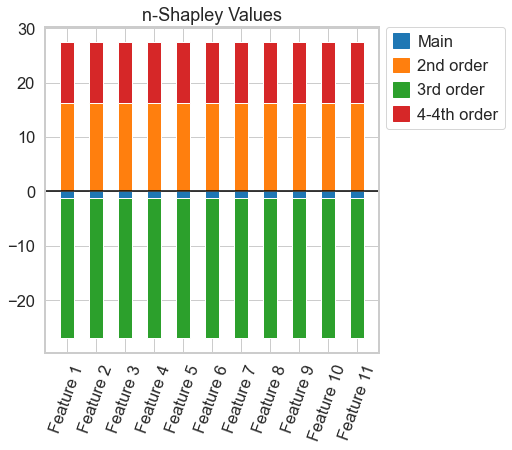

n-Shapley Values 5.499999999999716


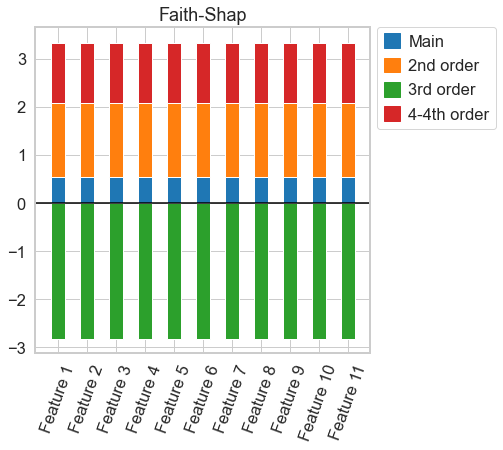

Faith-Shap 5.500000000002837


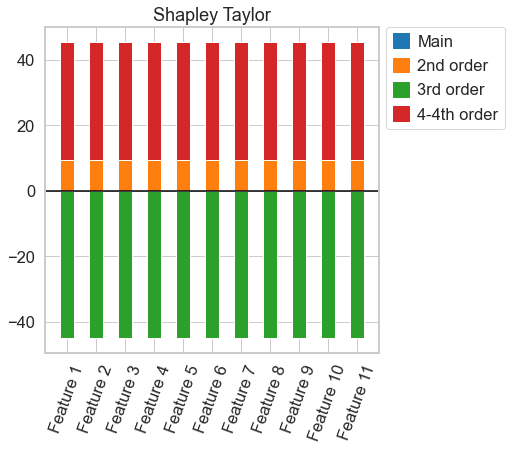

Shapley Taylor 5.500000000000455


In [5]:
import numpy as np
shapley = nshap.shapley_values(np.zeros((1,11)), v_func)
n_shapley = nshap.n_shapley_values(np.zeros((1,11)), v_func, 4)
faith_shap = nshap.faith_shap(np.zeros((1,11)), v_func, 4)
shapley_taylor = nshap.shapley_taylor(np.zeros((1,11)), v_func, 4)

for v in [shapley, n_shapley, faith_shap, shapley_taylor]:
    v.plot()
    print(v.name, v.sum())

In [4]:
interaction_shapley = nshap.delta_S(np.zeros((1,11)), v_func, 2)
for k,v in interaction_shapley[0].items():
    if np.abs(v) > 1e-8:
        print(k, v)